In [ ]:
!pip install defisheye
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:
import os
import glob
import shutil
import numpy as np
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision
from torchvision import transforms
from torchvision.models import resnet50
from defisheye import Defisheye


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Defish data and target labels

In [ ]:
# for DK's google drive
folder_path = '/content/drive/MyDrive/559A Project/train_labels'
# folder_path = '/content/drive/MyDrive/559A Project/'
image_path = '/content/drive/MyDrive/559A Project/train_part'


if not os.path.exists(folder_path):
    os.makedirs(folder_path)

if not os.path.exists(image_path):
    os.makedirs(image_path)

# if not os.path.exists(folder_path):
#     os.makedirs(output_defish_folder)

# folder_path = '/content/drive/MyDrive/train_labels'
# image_path = '/content/drive/MyDrive/train_part'
output_folder1 = '/content/label_image1'
output_folder = '/content/label_image'
output_defish_folder = '/content/defish_img'

dtype2 = 'equalarea'
format2 = 'fullframe'
fov2 = 158
pfov2 = 120

if not os.path.exists(output_folder1):
    os.makedirs(output_folder1)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(output_defish_folder):
    os.makedirs(output_defish_folder)

txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]


for txt_file in txt_files:

    txt_path = os.path.join(folder_path, txt_file)
    with open(txt_path, 'r') as file:
        lines = file.readlines()


    with Image.open(os.path.join(image_path, txt_file.replace('.txt', '.png'))) as img:
        width, height = img.size

        img_output_path = os.path.join(output_defish_folder, txt_file.replace('.txt', '.png'))
        convert_obj = Defisheye(os.path.join(image_path, txt_file.replace('.txt', '.png')), dtype=dtype2, format=format2, fov=fov2, pfov=pfov2)
        defish_image = convert_obj.convert()
        defish_image_pil = Image.fromarray(defish_image)
        defish_image_pil.save(img_output_path)

        empty_img = Image.new("RGB", (width, height), color=(0, 0, 0))
        draw = ImageDraw.Draw(empty_img)


        label_colors = {
            0: (255, 0, 0),
            1: (0, 255, 0),
            2: (0, 0, 255),
            3: (255, 255, 0),
            4: (255,0,255)
        }


        points = []
        labels = []
        for line in lines:
            line = line.strip().split()
            label = int(line[0])
            x, y, w, h = map(float, line[1:])
            points.append((x, y, w, h))
            labels.append(label)


        for point, label in zip(points, labels):
            x, y, w, h = point
            x1 = int((x - w/2) * width)
            y1 = int((y - h/2) * height)
            x2 = int((x + w/2) * width)
            y2 = int((y + h/2) * height)
            draw.rectangle([x1, y1, x2, y2], fill=label_colors[label], outline=label_colors[label], width=1)

        output_path1 = os.path.join(output_folder1, txt_file.replace('.txt', '.png'))
        output_path2 = os.path.join(output_folder, txt_file.replace('.txt', '.png'))

        empty_img.save(output_path1)

        label_image = os.path.join(output_folder1,txt_file.replace('.txt', '.png'))
        obj = Defisheye(label_image, dtype=dtype2, format=format2, fov=fov2, pfov=pfov2)
        new_image = obj.convert()
        new_image_pil = Image.fromarray(new_image)
        new_image_pil.save(output_path2)

print(f"All txt files converted and saved as PNG in {output_folder}")

All txt files converted and saved as PNG in /content/label_image


In [ ]:

image_path = '/content/defish_img'
label_path = '/content/label_image'
data_dir = '/content/data'

input_dir = os.path.join(data_dir, 'input')
groundtruth_dir = os.path.join(data_dir, 'groundtruth')


if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(groundtruth_dir):
    os.makedirs(groundtruth_dir)

image_files = glob.glob(os.path.join(image_path, '*'))
for file in image_files:
    shutil.copy(file, input_dir)

label_files = glob.glob(os.path.join(label_path, '*'))
for file in label_files:
    shutil.copy(file, groundtruth_dir)

print(f"Copied folders to {data_dir}")


Copied folders to /content/data


In [ ]:

class MyDataset(Dataset):
    def __init__(self, data_dir, train=True):
        file_names = glob.glob(os.path.join(data_dir, 'input', '*.*'))

        if train:
            self.img_names = [s for s in file_names if s[-7] != '3']  # include only training images
        else:
            self.img_names = [s for s in file_names if s[-7] == '3']  # include only test images
        self.label_names = [fname.replace(os.path.join('input'), os.path.join('groundtruth')).replace('jpg', 'png')
                            for fname in self.img_names]
        print(self.label_names)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.RandomRotation(15),  # Random rotation up to 15 degrees
            transforms.ToTensor(),
            transforms.Resize((740, 740)),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img = self.transform(imageio.v3.imread(self.img_names[idx]))
        label = np.expand_dims(imageio.v3.imread(self.label_names[idx], mode='L'), axis=-1)

        label[label == 0] = 0
        label[label == 29] = 1
        label[label == 76] = 2
        label[label == 150] = 3
        label[label == 226] = 4
        label[label == 105] = 4
        label[label == 179] = 4

        label = torch.from_numpy(label).permute(2, 0, 1)
        label = transforms.Resize((740, 740), interpolation=transforms.InterpolationMode.NEAREST)(label)

        return img, label


In [ ]:
def get_dataloaders(data_dir, batch_size=32, num_workers=2):
  #define train and test datasets
  train_data = MyDataset(data_dir)
  test_data = MyDataset(data_dir, train=False)
  test_data, valid_data = torch.utils.data.random_split(test_data, [0.5,0.5])
  #define train and test dataloaders
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
  test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=False, drop_last=True)
  valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=False, drop_last=True)

  return train_dataloader, test_dataloader, valid_dataloader

# set the data directory to the appropriate directory
data_dir = '/content/data'

# set batch_size and number of workers
batch_size = 6
num_workers = 2
train_dataloader, test_dataloader, valid_dataloader = get_dataloaders(data_dir, batch_size, num_workers)

[]
[]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
for index, (ims, labels) in enumerate(test_dataloader):
  print(torch.unique(labels))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([0, 1, 2, 3, 4], dtype=torch.uint8)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


label:  torch.Size([6, 740, 740, 1])
img:  torch.Size([6, 740, 740, 3])
tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor(0.)


tensor(1.0000)
torch.Size([6, 740, 740, 1])


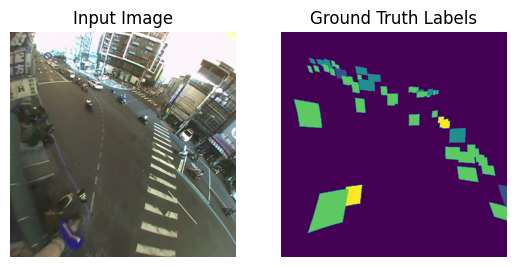

label:  torch.Size([6, 740, 740, 1])
img:  torch.Size([6, 740, 740, 3])
tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor(0.)


tensor(1.0000)
torch.Size([6, 740, 740, 1])


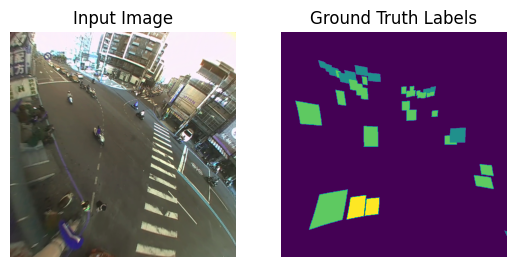

label:  torch.Size([6, 740, 740, 1])
img:  torch.Size([6, 740, 740, 3])
tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor(0.)
tensor(1.0000)


torch.Size([6, 740, 740, 1])


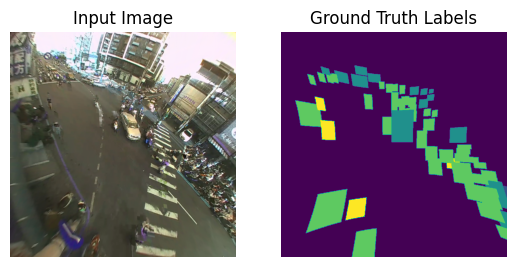

label:  torch.Size([6, 740, 740, 1])
img:  torch.Size([6, 740, 740, 3])
tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor(0.)
tensor(1.0000)


torch.Size([6, 740, 740, 1])


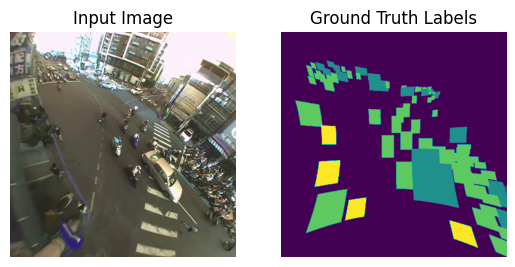

label:  torch.Size([6, 740, 740, 1])
img:  torch.Size([6, 740, 740, 3])
tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tensor(0.)
tensor(1.0000)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([6, 740, 740, 1])


KeyboardInterrupt: 

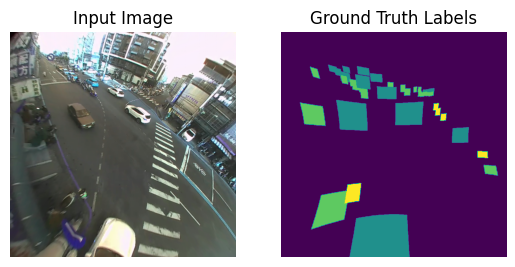

In [ ]:
def visualize_data(dataloader):
  cmap = plt.get_cmap('viridis', 6)
  for index, (ims, labels) in enumerate(dataloader):
      labels = torch.permute(labels, (0,2,3,1))
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(1)
      plt.clf()
      print("label: ", labels.shape)
      print("img: ", ims.shape)
      print(torch.unique(labels))

      plt.subplot(1,2,1)
      plt.imshow(ims[0,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(labels[0, :, :, 0].squeeze())
      print(labels.shape)
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

visualize_data(train_dataloader)

In [ ]:
def precision(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdims=True)
  prec = MulticlassPrecision(average='macro', num_classes=5, ignore_index=1).to(device)
  batch_precision = prec(y_true, y_pred)
  return batch_precision

def recall(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1, keepdims=True)
  rec = MulticlassRecall(average='macro', num_classes=5, ignore_index=1).to(device)
  batch_precision = rec(y_true, y_pred)
  return batch_precision

def fmeasure(y_true, y_pred):
  p = precision(y_true, y_pred)
  r = recall(y_true, y_pred)
  fmeasure = 2*(p * r)/(p + r + 1e-7)
  return fmeasure

In [ ]:
from torchvision.models import resnet152
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.residual_adjust = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        residual = self.residual_adjust(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class YOLOv3(nn.Module):
    def __init__(self, num_classes=5):
        super(YOLOv3, self).__init__()

        # Backbone
        self.backbone = self._make_backbone()

        # Detection Head
        self.head = nn.Sequential(
            ResidualBlock(2048, 512),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            ResidualBlock(1024, 512),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 5 * (5 + num_classes), kernel_size=1),
            nn.BatchNorm2d(5 * (5 + num_classes)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(5 * (5 + num_classes), 5, kernel_size=1)
        )

    def _make_backbone(self):
        # Load pre-trained ResNet152
        resnet = resnet152(pretrained=True)

        # Remove fully connected layer and average pooling layer
        backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Replace the final layers to match the output size needed for YOLO head
        backbone[-1][-1] = nn.Conv2d(2048, 2048, kernel_size=3, stride=1, padding=1)
        backbone[-1][-2] = nn.BatchNorm2d(2048)

        return backbone

    def forward(self, x):
        x = self.backbone(x)

        # Detection head
        x = self.head(x)

        # Resize the output to match the input size
        x = F.interpolate(x, size=(740, 740), mode='nearest')

        return x

#model = YOLOv3(num_classes).to(device)
# Test the model with a dummy input
#dummy_input_img = torch.randn(6, 3, 800, 800).to(device)  # batch_size, channels, height, width
#output = model(dummy_input_img)


In [ ]:
@torch.no_grad
def validate(model, dataloader,criterion):
  model.eval()
  model.to(device)
  running_loss = 0.0
  all_outputs = []
  all_labels = []
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.squeeze(1).long().to(device)
    #print(torch.unique(labels))
    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)

    #save all outputs
    all_outputs.append(outputs)
    all_labels.append(labels)

  # Calculate epoch loss and eval metrics
  epoch_loss = running_loss / len(dataloader.dataset)
  all_outputs = torch.cat(all_outputs, dim=0)
  all_labels = torch.cat(all_labels, dim=0)
  all_labels = torch.unsqueeze(all_labels, dim=1)
  f1 = fmeasure(all_labels, all_outputs)

  print(f'Val Loss: {epoch_loss:.3f} \t F1-Score: {f1}')

  return epoch_loss, f1

def training_loop(model, dataloader, criterion, optimizer):

    model.train()
    model.to(device)
    running_loss = 0.0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True)
    for i, (inputs, labels) in progress_bar:
        inputs = inputs.to(device)
        #print(inputs.shape)
        # Reshape labels to match the expected format
        labels = torch.squeeze(labels, dim=1)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)

        # Check if labels are within bounds
        if torch.any(labels < 0) or torch.any(labels >= model.head[-1].out_channels):
            raise ValueError(f"Labels out of bounds. Expected range: [0, {model.head[-1].out_channels - 1}]")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the gradients wrt the loss, but the outcome is worse

        #weights = torch.tensor([1 if t.item() == 0 else 1.5 for t in torch.unique(labels)], device=device)

        # Apply weights to the loss
        #weighted_loss = (loss * weights).mean()

        # Backward pass and optimization
        #weighted_loss.backward()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_description(f"Train Loss: {loss.item():.4f}")

        # Print unique labels and their counts
        unique_labels, counts = torch.unique(labels, return_counts=True)
        #print(f"Batch {i+1} Unique Labels: {unique_labels} Counts: {counts}")

    progress_bar.close()

    # Calculate epoch loss
    epoch_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {epoch_loss:.4f}")

    return epoch_loss


def fit(hparams, train_loader, valid_loader, model_name='test'):
  model = hparams['model_type']()
  best_loss = np.inf
  f1 = 0

  results = dict(train_loss=[], val_loss=[], val_f1=[])
  #initialize the optimizers
  if hparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  elif hparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
  else:
    raise NotImplementedError
  #optimizer = torch.optim.AdamW(model.parameters(), lr=0.000111)

  class_weights_tensor = torch.tensor(hparams['class_weights'], device=device, dtype=torch.float32)

  # Initialize the criterion
  #criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
  criterion = nn.CrossEntropyLoss()


  #run training for n epochs
  for epoch in range(hparams['n_epochs']):
    print("Epoch {}".format(epoch+1))
    train_loss = training_loop(model, train_loader,criterion,optimizer)
    val_loss, val_f1 = validate(model, valid_loader, criterion)

    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['val_f1'].append(val_f1)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model
      f1 = val_f1


  torch.save(best_model, f'{model_name}z.pt')

  return best_model, best_loss, f1, results

def get_hparams(model_type=YOLOv3,n_epochs=15,learning_rate=0.000125, optimizer='adam'):
  hparams = {}
  hparams['data_dir'] = data_dir
  hparams['n_epochs'] = n_epochs
  hparams['learning_rate'] = learning_rate
  hparams['model_type'] = YOLOv3
  hparams['optimizer'] = optimizer
  return hparams


####### Your code here ##########

# set the class_weigths keys with the three different settings mentioned above and fit the baseline model for each of them

momentum=0.9
hparams = get_hparams(model_type=YOLOv3)
print(hparams)

device = 'cuda'
best_model, val_loss, f1, results = fit(hparams, train_dataloader, valid_dataloader, model_name='YOLOv3')
######## Your code here #########


{'data_dir': '/content/data', 'n_epochs': 15, 'learning_rate': 0.000125, 'model_type': <class '__main__.YOLOv3'>, 'optimizer': 'adam', 'class_weights': [0.1, 1, 1, 1, 1]}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 128MB/s]


Epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Loss: 0.8194: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


Train Loss: 46.2417


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


Val Loss: 0.525 	 F1-Score: 0.5964868664741516
Epoch 2


Train Loss: 0.6932: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 37.2640


100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


Val Loss: 0.461 	 F1-Score: 0.6118918061256409
Epoch 3


Train Loss: 0.6067: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 31.9516


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


Val Loss: 0.398 	 F1-Score: 0.6227471828460693
Epoch 4


Train Loss: 0.4960: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


Train Loss: 27.3142


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


Val Loss: 0.363 	 F1-Score: 0.6130016446113586
Epoch 5


Train Loss: 0.4270: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


Train Loss: 23.5701


100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


Val Loss: 0.309 	 F1-Score: 0.6264245510101318
Epoch 6


Train Loss: 0.3808: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 20.3732


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Val Loss: 0.277 	 F1-Score: 0.635837197303772
Epoch 7


Train Loss: 0.3502: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


Train Loss: 17.9729


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


Val Loss: 0.279 	 F1-Score: 0.622904360294342
Epoch 8


Train Loss: 0.3100: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 16.8452


100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


Val Loss: 0.240 	 F1-Score: 0.6208632588386536
Epoch 9


Train Loss: 0.2776: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 14.6497


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


Val Loss: 0.215 	 F1-Score: 0.62638920545578
Epoch 10


Train Loss: 0.2358: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Train Loss: 13.3971


100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Val Loss: 0.197 	 F1-Score: 0.6223524808883667
Epoch 11


Train Loss: 0.2352: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Train Loss: 12.2015


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


Val Loss: 0.192 	 F1-Score: 0.6293241381645203
Epoch 12


Train Loss: 0.2145: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Train Loss: 11.3636


100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


Val Loss: 0.176 	 F1-Score: 0.6335304379463196
Epoch 13


Train Loss: 0.2034: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 10.5486


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


Val Loss: 0.168 	 F1-Score: 0.6296298503875732
Epoch 14


Train Loss: 0.1840: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


Train Loss: 9.8645


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Val Loss: 0.161 	 F1-Score: 0.6373224258422852
Epoch 15


Train Loss: 0.1887: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Train Loss: 9.3993


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


Val Loss: 0.158 	 F1-Score: 0.6282469034194946


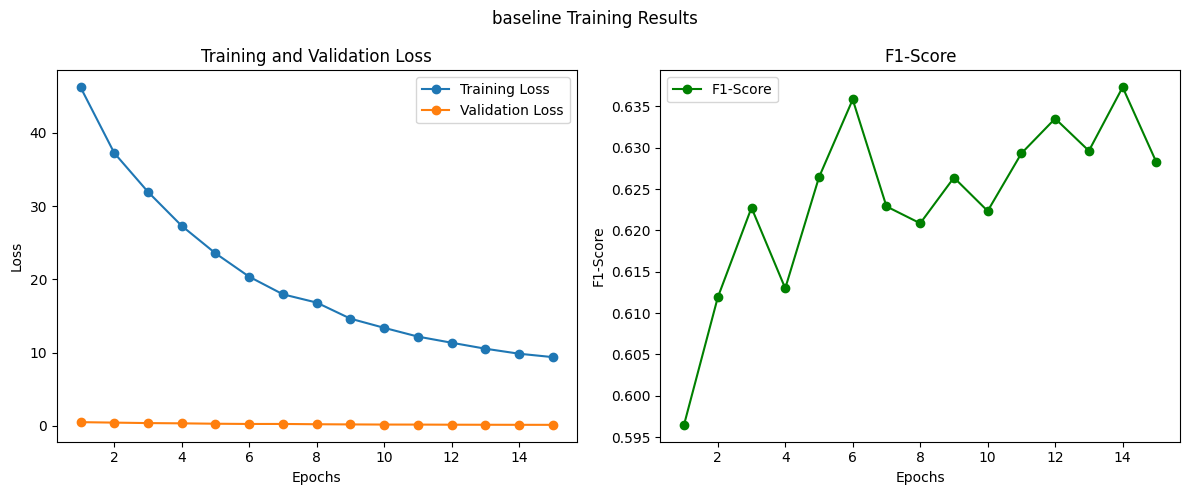

In [ ]:
def load_model(path):
  model = torch.load(path)
  return model

def plot_results(results, model_name):
    # Extracting metrics
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    val_f1 = results['val_f1']
    f1_values = [f1.item() for f1 in val_f1]
    # Plotting
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_values, label='F1-Score', marker='o', color='green')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.suptitle(f'{model_name} Training Results')
    plt.tight_layout()
    plt.show()

plot_results(results, model_name='baseline')

In [ ]:


@torch.no_grad
def visualize(model, dataloader):
  cmap = plt.get_cmap('viridis', 6)
  for index, (ims, labels) in enumerate(dataloader):
      ims = ims.to(device)
      labels_est = model(ims)
      # import code;code.interact(local=dict(globals(), **locals()))
      labels = torch.permute(labels, (0,2,3,1)).cpu()
      labels_est = torch.permute(labels_est, (0,2,3,1)).cpu()
      ims = torch.permute(ims, (0,2,3,1)).cpu()
      plt.figure(figsize=(15,8))
      plt.clf()

      num_img = 10
      plt.subplot(1,4,1)
      plt.imshow(ims[num_img,:,:,:])
      plt.title('Input Image')
      plt.axis('off')

      plt.subplot(1,4,2)
      plt.imshow(labels[num_img,:,:,:].squeeze())
      plt.title('Ground Truth Labels')
      plt.axis('off')

      plt.subplot(1,4,3)
      plt.imshow(labels_est[num_img,:,:,1].squeeze())
      plt.title('Probability of Foreground')
      plt.axis('off')
      print(labels.shape)
      print(ims.shape)
      print(labels_est.shape)

      plt.subplot(1,4,4)
      plt.imshow(np.argmax(labels_est[num_img,:,:,:],axis=-1))
      plt.title('Predicted Labels')
      plt.axis('off')

      plt.pause(.1)

      if index == 10:
          break

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize2(model, dataloader):
    cmap = plt.get_cmap('viridis', 6)
    for index, (ims, labels) in enumerate(dataloader):
        ims = ims.to(device)
        labels_est = model(ims)

        labels = torch.permute(labels, (0,2,3,1)).cpu()
        labels_est = torch.permute(labels_est, (0,2,3,1)).cpu()
        ims = torch.permute(ims, (0,2,3,1)).cpu()

        plt.figure(figsize=(15,8))
        plt.clf()

        num_img = 10

        plt.subplot(1, 6, 1)
        plt.imshow(labels[num_img,:,:,:].squeeze())
        plt.title('Ground Truth Labels')
        plt.axis('off')

        plt.subplot(1, 6, 2)
        plt.imshow(labels_est[num_img,:,:,0].squeeze())
        plt.title('Probability of Background')
        plt.axis('off')
        print(f"Background: Max: {labels_est[num_img,:,:,0].max().item()}, Min: {labels_est[num_img,:,:,0].min().item()}")

        plt.subplot(1, 6, 3)
        plt.imshow(labels_est[num_img,:,:,1].squeeze())
        plt.title('Probability of Class 1')
        plt.axis('off')
        print(f"Background: Max: {labels_est[num_img,:,:,1].max().item()}, Min: {labels_est[num_img,:,:,1].min().item()}")

        plt.subplot(1, 6, 4)
        plt.imshow(labels_est[num_img,:,:,2].squeeze())
        plt.title('Probability of Class 2')
        plt.axis('off')
        print(f"Background: Max: {labels_est[num_img,:,:,2].max().item()}, Min: {labels_est[num_img,:,:,2].min().item()}")

        plt.subplot(1, 6, 5)
        plt.imshow(labels_est[num_img,:,:,3].squeeze())
        plt.title('Probability of Class 3')
        plt.axis('off')
        print(f"Background: Max: {labels_est[num_img,:,:,3].max().item()}, Min: {labels_est[num_img,:,:,3].min().item()}")

        plt.subplot(1, 6, 6)
        plt.imshow(labels_est[num_img,:,:,4].squeeze())
        plt.title('Probability of Class 4')
        plt.axis('off')
        print(f"Background: Max: {labels_est[num_img,:,:,4].max().item()}, Min: {labels_est[num_img,:,:,4].min().item()}")

        plt.pause(.1)

        if index == 10:
            break


torch.Size([32, 740, 740, 1])
torch.Size([32, 740, 740, 3])
torch.Size([32, 740, 740, 5])


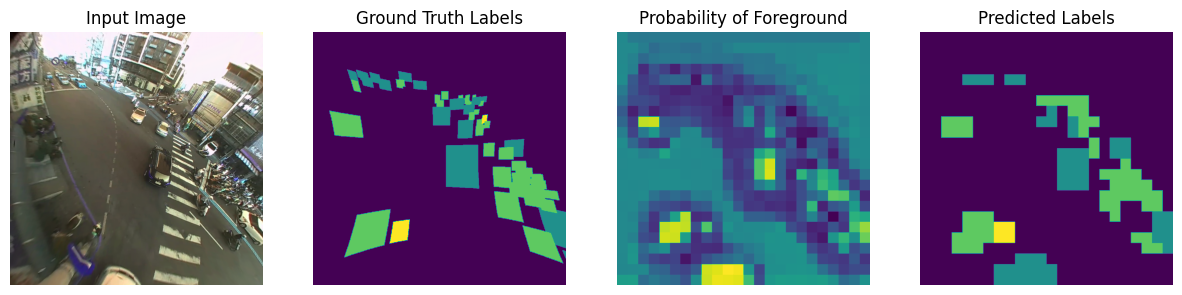

Background: Max: 2.5462985038757324, Min: -5.263309478759766
Background: Max: 0.15628212690353394, Min: -2.403163433074951
Background: Max: 7.115423202514648, Min: -2.1326956748962402
Background: Max: 4.105179309844971, Min: -2.2319812774658203
Background: Max: 4.547008514404297, Min: -2.085085153579712


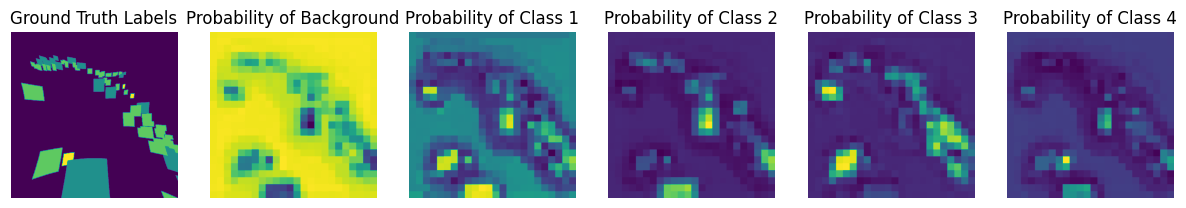

In [ ]:
model = load_model('/content/YOLOv3z.pt')
#visulize input, target, prediction
visualize(model, test_dataloader)
#visulize prediction for each class
visualize2(model, test_dataloader)

torch.Size([32, 740, 740, 1])
torch.Size([32, 740, 740, 3])
torch.Size([32, 740, 740, 5])


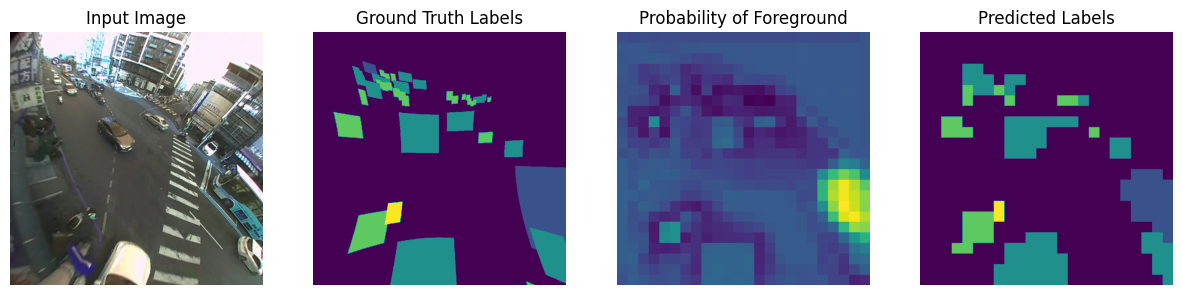

Background: Max: 3.0671353340148926, Min: -5.285489559173584
Background: Max: 2.4960391521453857, Min: -2.2305309772491455
Background: Max: 4.379406929016113, Min: -2.2303543090820312
Background: Max: 5.236041069030762, Min: -1.6377589702606201
Background: Max: 3.565164089202881, Min: -2.4959535598754883


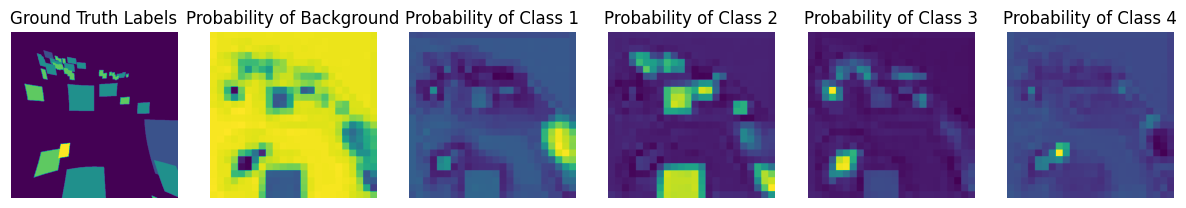

In [ ]:
model = load_model('/content/YOLOv3z.pt')
visualize(model, test_dataloader)
visualize2(model, test_dataloader)

In [ ]:
print(model)

Import YOLOv8 do the object detection job

In [ ]:
!pip install ultralytics

In [ ]:
import shutil

label_folder = "/content/drive/MyDrive/train_labels"
image_folder = "/content/drive/MyDrive/train_part"
l_dest_folder = "/content/data2/labels"
i_dest_folder = "/content/data2/images"

# Copy label_folder and its contents to des_folder
shutil.copytree(label_folder, l_dest_folder)

# Copy image_folder and its contents to des_folder
shutil.copytree(image_folder, i_dest_folder)

print("Folders copied successfully!")

In [ ]:
from ultralytics import YOLO

# Model
model = YOLO('/content/yolov8n.pt')
model.to('cuda')  # Move the model to the appropriate device (e.g., GPU)
model.train(data='/content/data.yaml', epochs=10)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
model = YOLO('/content/runs/detect/train3/weights/best.pt')
results_fished = model.predict('/content/drive/MyDrive/data_empty/input/camera3_A_0.png')
result_fished= results_fished[0]

img_fished = Image.fromarray(result_fished.plot()[:,:,::-1])

plt.imshow(img_fished)